In [59]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import numpy as np
import itertools

In [60]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

In [61]:
stops = set(stopwords.words("english"))
def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [62]:
train = pd.read_csv('C:/Users/diaco/OneDrive/Desktop/FinalProject/data/Constraint_English_Train.csv')
val = pd.read_csv('C:/Users/diaco/OneDrive/Desktop/FinalProject/data/Constraint_English_Val.csv')
test = pd.read_csv('C:/Users/diaco/OneDrive/Desktop/FinalProject/data/Constraint_English_Test.csv')

In [63]:
train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [65]:
val.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [64]:
test.head()

,id,tweet
0,1,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...
3,4,States reported 630 deaths. We are still seein...
4,5,This is the sixth time a global health emergen...


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


In [68]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB


In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
dtypes: int64(1), object(1)
memory usage: 33.6+ KB


In [69]:
train.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

In [71]:
val.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

In [70]:
test.isnull().sum()

id       0
tweet    0
dtype: int64

In [72]:
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
#test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

In [73]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))
    

SVM
val:
[[ 963   57]
 [  83 1037]]
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      1020
        real       0.95      0.93      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.94      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9345794392523364
Precison :  0.9348008619335585
Recall :  0.9345794392523364
F1 :  0.9345519215989282


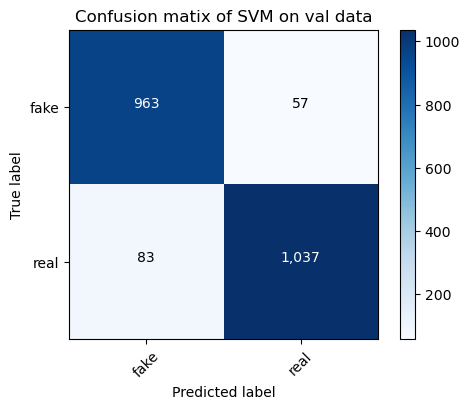

In [75]:
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', LinearSVC())
    ])
fit = pipeline.fit(train['tweet'],train['label'])
print('SVM')
print ('val:')
pred=pipeline.predict(val['tweet'])
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

val_ori = pd.read_csv('C:/Users/diaco/OneDrive/Desktop/FinalProject/data/Constraint_English_Val.csv')
svm_val_misclass_df = val_ori[pred!=val['label']]